# Deep Open Classifier Implementation
This is an implementation of a Deep Open Classifier which manages to provide rejection or acceptance of classifications made on new data based on previously computed class thresholds.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from scipy.stats import norm as dist_model
from numpy import max, round, where, argwhere
from sklearn.multiclass import OneVsRestClassifier
from keras.layers import Dense, Input
from keras.models import Sequential
from utils import compute_threshold, fit_distribution_single_class

import warnings
warnings.filterwarnings('ignore')

# Generate Fake Data
We create a fake dataset with three classes represented as blobs defined by two features, $x_1$ and $x_2$

,x1,x2,class
387,0.243119,-4.697559,2
939,0.481486,-5.467536,2
547,2.103413,3.741144,1
56,1.072693,-5.093129,2
704,0.845481,-5.935686,2


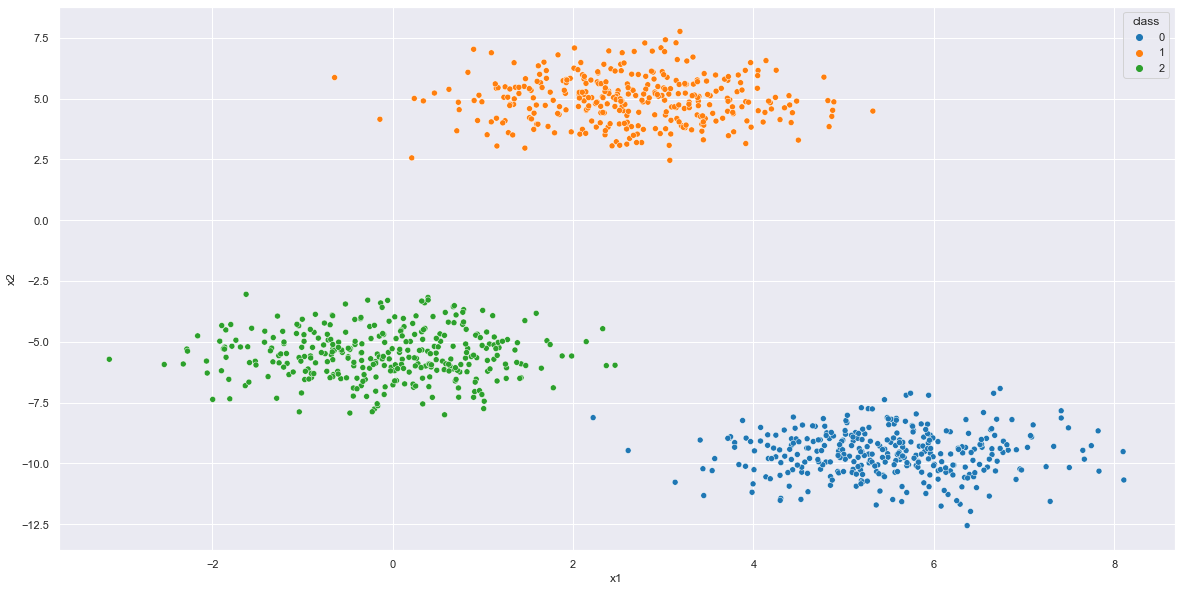

In [3]:
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, random_state=10)
df = pd.DataFrame(X, columns=['x1', 'x2'])
df['class'] = y
sns.set()
fig, axs = plt.subplots(figsize=(20, 10))
sns.scatterplot(df['x1'], df['x2'], hue=df['class'], palette='tab10')
df.sample(5)

We now filter out class 2 and we will treat it as an unknown (new) class that our model will not see during training. We will end up with only 1 and 0 labels.

,x1,x2,class
633,3.018340,5.385014,1
401,5.351464,-10.106737,0
286,5.104049,-10.250727,0
902,1.538269,4.168281,1
195,6.183035,-10.314360,0


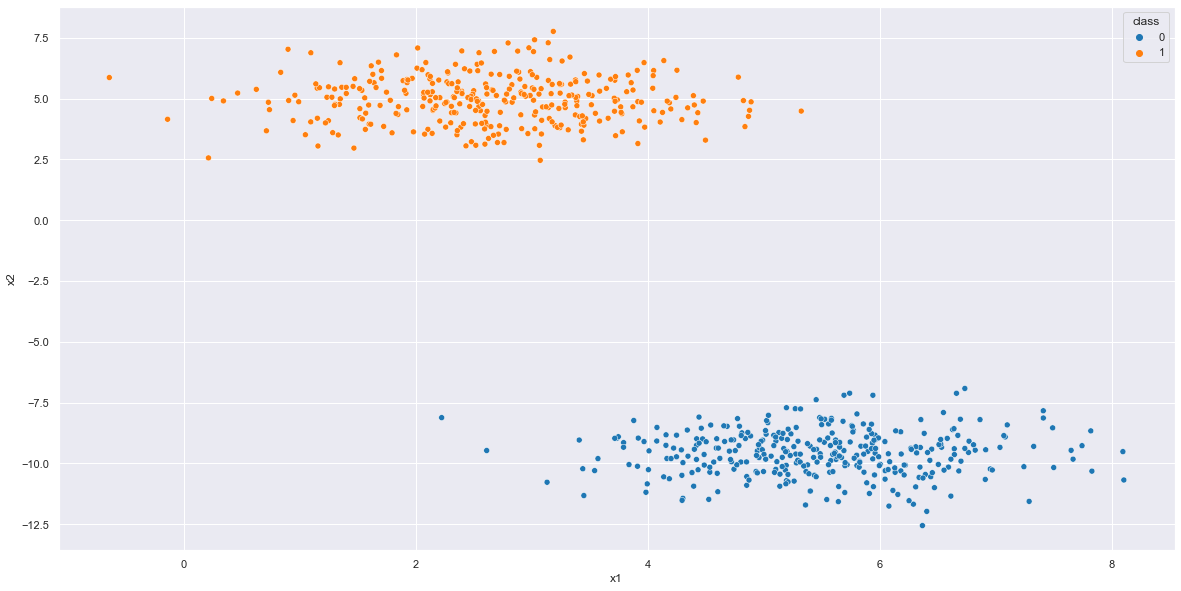

In [4]:
df_filter = df[df['class'] != 2]
fig, axs = plt.subplots(figsize=(20, 10))
sns.scatterplot(df_filter['x1'], df_filter['x2'], hue=df_filter['class'], palette='tab10')
df_filter.sample(5)

We convert the labels into binary to make use of the NN architecture

In [5]:
classes = pd.get_dummies(df_filter['class'], prefix='class')
df_filter_binary_class = pd.concat([df_filter[['x1', 'x2']], classes], axis=1)
df_filter_binary_class.sample(5)

,x1,x2,class_0,class_1
323,6.454253,-10.387851,1,0
459,4.841958,-8.982939,1,0
478,4.534961,-10.161854,1,0
313,4.164823,-9.804221,1,0
942,3.491252,5.176578,0,1


In [6]:
X_train = df_filter_binary_class[['x1', 'x2']].values
y_train = df_filter_binary_class[['class_0', 'class_1']].values
print(X_train)
print(y_train)

[[ 4.56889035 -9.9492391 ]
 [ 2.35388502  3.51466401]
 [ 1.63916863  5.65612285]
 ...
 [ 5.58342785 -8.22617187]
 [ 4.89123569  4.86995972]
 [ 1.09272697  4.04641343]]
[[1 0]
 [0 1]
 [0 1]
 ...
 [1 0]
 [0 1]
 [0 1]]


# Train the Classifier
We will train a model to classify N-1 classes so that one of the prvious blobs acts as the unknown data, is our case all data points labeled as **class 2** will act as new unseen data.

In other words, our model will only train with the above dataset.

In [7]:
def base_model1():
    model = Sequential()
    model.add(Dense(10, input_dim=2, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))
    return model

In [8]:
mdl = base_model1()
mdl.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(mdl.summary())
mdl.fit(X_train, y_train, epochs=5, batch_size=10)
print(mdl.predict(X_train[0:1,:]))

2022-04-20 10:09:48.180203: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-20 10:09:48.184602: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-20 10:09:48.184889: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-20 10:09:48.185861: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                30        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 22        
Total params: 162
Trainable params: 162
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
67/67 [==============================] - 1s 1ms/step - loss: 0.3315 - accuracy: 0.7916
Epoch 2/5
67/67 [==============================] - 0s 1ms/step - loss: 0.1545 - accuracy: 1.0000
Epoch 3/5
67/67 [==============================] - 0s 1ms/step - loss: 0.0593 - accuracy: 1.0000
Epoch 4/5
67/67 [==============================] - 0s 1ms/step - loss: 0.0230 - accuracy: 1.

# Use the Model for Predictions
Using our model, **perfectly trained for classes 1 and 0**, we now **predict on the entire dataset** to see how the model classifies what initially was supposed to be class 2.

In [9]:
df[['class_0', 'class_1']] = (mdl.predict(df[['x1', 'x2']].values) > 0.5).astype(int)
df.head()

,x1,x2,class,class_0,class_1
0,4.568890,-9.949239,0,1,0
1,2.353885,3.514664,1,0,1
2,-0.017502,-6.050385,2,1,0
3,0.125486,-4.379234,2,1,0
4,1.639169,5.656123,1,0,1


Even though the lower left blob does not clearly belong to any of the two classes, the model fits it within one of the two because **it doen't know anything else than classes 0 and 1**, here we face the **closed world assumption** problem. We trained our model under the assumption that data points can only belong to classes 0 and 1.

Ideally we would like our model to identify new data points that do not belong to any of the trained classes as **unknown**.

<AxesSubplot:xlabel='x1', ylabel='x2'>

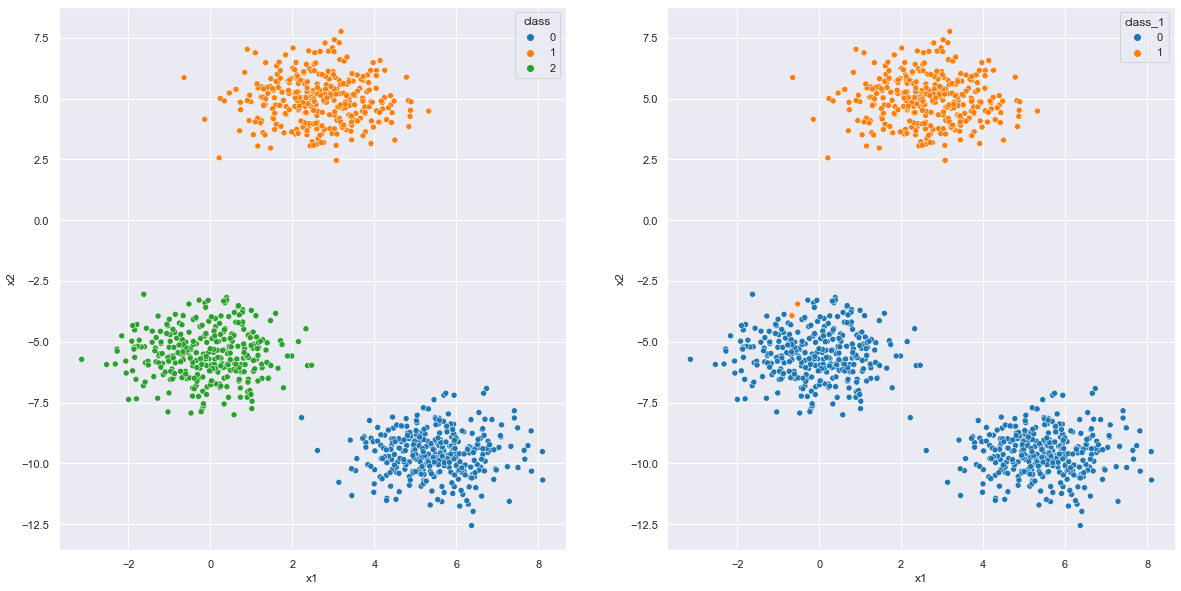

In [10]:
fix, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
sns.scatterplot(df["x1"], df["x2"], hue=df["class"], palette="tab10", ax=axs[0])
sns.scatterplot(
    df["x1"],
    df["x2"],
    hue=df["class_1"],
    palette="tab10",
    ax=axs[1],
)

# Deep Open Classifier Implementation
We now implement the rejection capabilities to our model using the strategy proposed in https://arxiv.org/abs/1709.08716

In [11]:
def base_model():
    model = Sequential()
    model.add(Dense(10, input_dim=2, activation='relu'))
    model.add(Dense(10, activation='relu'))
    return model


def deep_open_classifier(model):
    model.add(Dense(15, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))
    return model

In [12]:
doc = deep_open_classifier(base_model())
doc.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
doc.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_4 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_5 (Dense)              (None, 15)                165       
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 32        
Total params: 337
Trainable params: 337
Non-trainable params: 0
_________________________________________________________________


In [13]:
doc.fit(X_train, y_train, epochs=5, batch_size=10)

Epoch 1/5
67/67 [==============================] - 0s 1ms/step - loss: 0.5717 - accuracy: 0.6897
Epoch 2/5
67/67 [==============================] - 0s 1ms/step - loss: 0.1287 - accuracy: 1.0000
Epoch 3/5
67/67 [==============================] - 0s 1ms/step - loss: 0.0130 - accuracy: 1.0000
Epoch 4/5
67/67 [==============================] - 0s 1ms/step - loss: 0.0035 - accuracy: 1.0000
Epoch 5/5
67/67 [==============================] - 0s 1ms/step - loss: 0.0017 - accuracy: 1.0000


## Compute the probability for the two classes on every trained data point
We can see that for every data point we have two numbers, they correspond to how likely the point is to belong to **class 0 or 1** respectively.

In [14]:
y_proba_pred = doc.predict(df_filter[['x1', 'x2']].values)
print(y_proba_pred.shape)
print(y_proba_pred)

(667, 2)
[[0.9933002  0.09787176]
 [0.08005278 0.9555623 ]
 [0.03821324 0.98286855]
 ...
 [0.98943675 0.12158174]
 [0.02175047 0.99127483]
 [0.08872729 0.94843954]]


## Compute mean and standard deviation for each class
We compute the mean and standard deviation of a fitted normal distribution for each class based on the probability of every sample in the i class of belonging to the i class.

That is, for every point that we already know it belongs to class 1 we fit a normal distribution for their class 1 probabilities, then we compute the mean of their class 1 probability, the same for class 0.

We end up with a list that contains the mean and standard deviation of every class, that is:
$$[(\mu_0, \sigma_0),\,(\mu_1, \sigma_1)]$$

In [15]:
mu_stds = []
x_dists = []
# iterate over every class
for i in range(y_proba_pred.shape[1]):
    # for each sample belonging to class i
    # a gaussian distirbution fit is made 
    # for all probabilities of them being class i
    mu, std, x_dist = fit_distribution_single_class(
        y_proba_pred[argwhere(df_filter['class'].values == i), i]
        )
    mu_stds.append([mu, std])
    x_dists.append(np.array(x_dist))
class_thresholds = compute_threshold(mu_stds, alpha=3)
print(mu_stds)

[[1.0, 0.0075093703], [1.0, 0.026960587]]


## Graphical representation of the process of distribution fitting

In [16]:
def viz_prob_distribution(class_):
    idx = class_
    mu_class = mu_stds[idx][0]
    std_class = mu_stds[idx][1]
    ti = class_thresholds[idx]
    x_norm = np.linspace(mu_class - 3 * std_class,
                         mu_class + 3 * std_class,
                         200)
    y_norm_dist = dist_model.pdf(x_norm, mu_class, std_class)
    # plotting
    plt.figure(figsize=(14, 7))
    plt.plot(x_norm, y_norm_dist, 'k', linewidth=0.8)
    plt.title(f'Probability distribution for class {class_}')
    plt.grid(linestyle='--')
    plt.scatter(x_dists[idx], np.zeros(x_dists[idx].shape), edgecolors='k')
    plt.vlines([1 - std_class], 0, max(y_norm_dist), 'red', linestyle='--', label='std')
    plt.vlines([ti], 0, max(y_norm_dist), 'blue', linestyle='--', label='t_i')
    plt.legend()
    print('std: ', std_class)
    print('t_i: ', ti)

std:  0.0075093703
t_i:  0.9775
std:  0.026960587
t_i:  0.9191


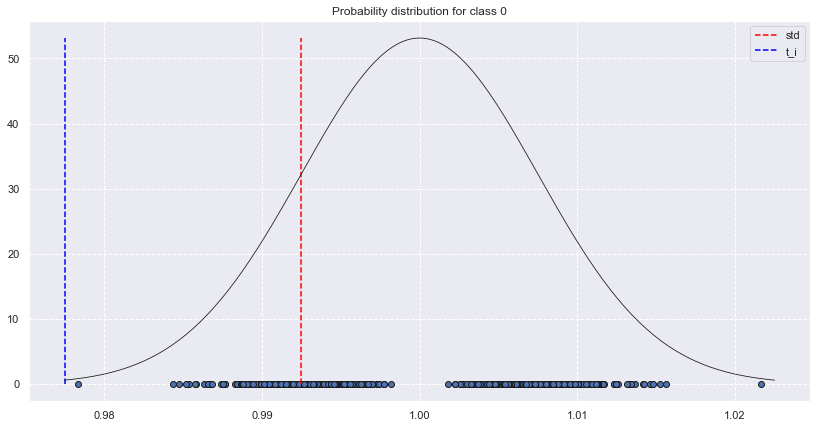

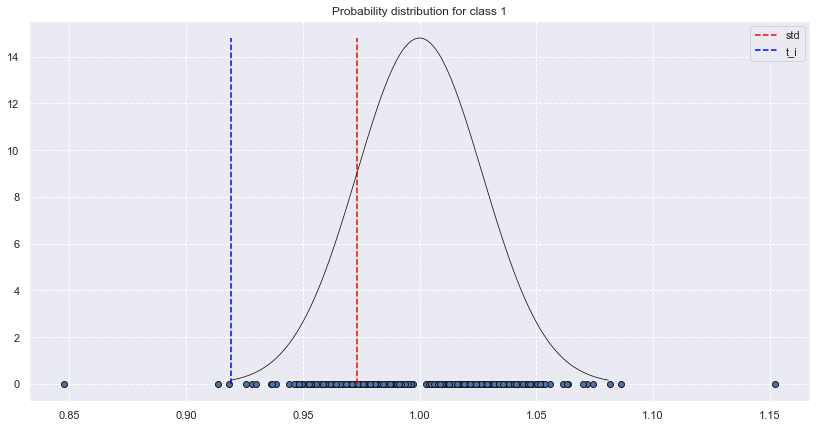

In [17]:
for i in range(y_proba_pred.shape[1]):
    viz_prob_distribution(i)

In [18]:
print(class_thresholds)

[0.9775 0.9191]


# Make Prediction With Rejection Capabilities 

In [19]:
def accept_reject_prediction(prob_list):
    if np.all(prob_list < class_thresholds):
        return 'UNKWNOWN'
    else:
        return int(np.argmax(prob_list))

In [20]:
y_pred_proba = pd.DataFrame(doc.predict(df[['x1', 'x2']]))
df['prediction'] = y_pred_proba.apply(accept_reject_prediction, axis=1)
df['prediction'] = df['prediction'].astype(str)
df = df.sort_values(by='prediction', ascending=True)
df.sample(5, random_state=2)

,x1,x2,class,class_0,class_1,prediction
616,5.764472,-8.481088,0,1,0,0
947,0.702215,-3.897238,2,1,0,UNKWNOWN
647,-1.865399,-5.302128,2,1,0,UNKWNOWN
77,5.024940,-8.242782,0,1,0,0
402,1.249830,-5.920129,2,1,0,UNKWNOWN


<AxesSubplot:xlabel='x1', ylabel='x2'>

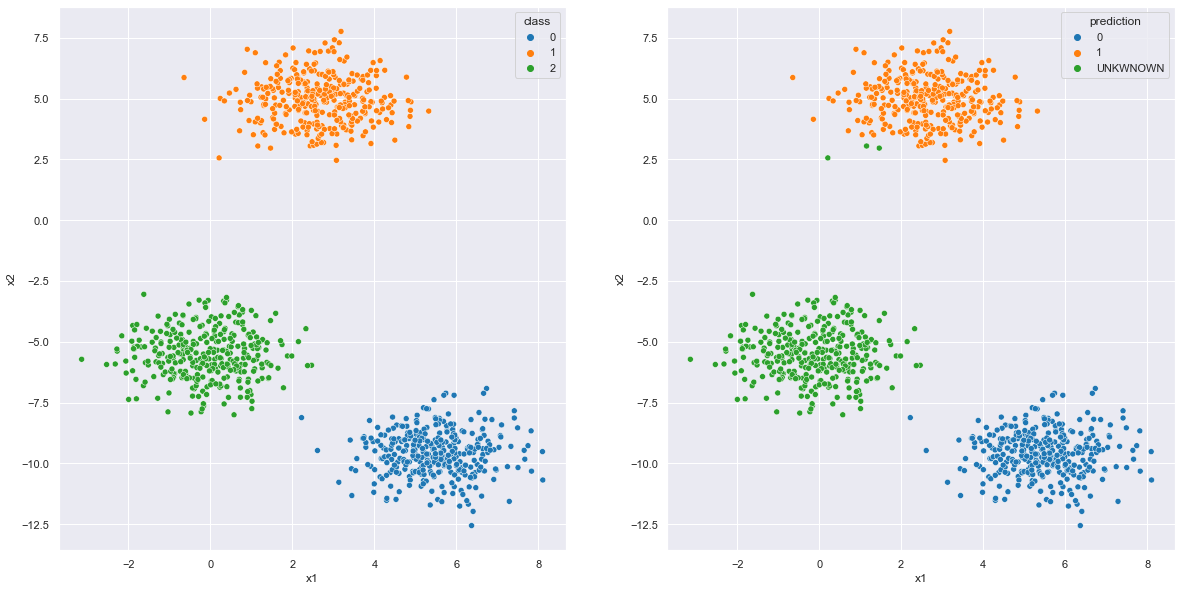

In [21]:
fix, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
sns.scatterplot(df["x1"], df["x2"], hue=df["class"], palette="tab10", ax=axs[0])
sns.scatterplot(
    df["x1"],
    df["x2"],
    hue=df["prediction"],
    palette="tab10",
    ax=axs[1],
)